In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py

In [377]:
## Plotting fonts
lin_thickness=4
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}

# RH FILTER

## Generating / plotting plant filter

83


<Figure size 432x288 with 0 Axes>

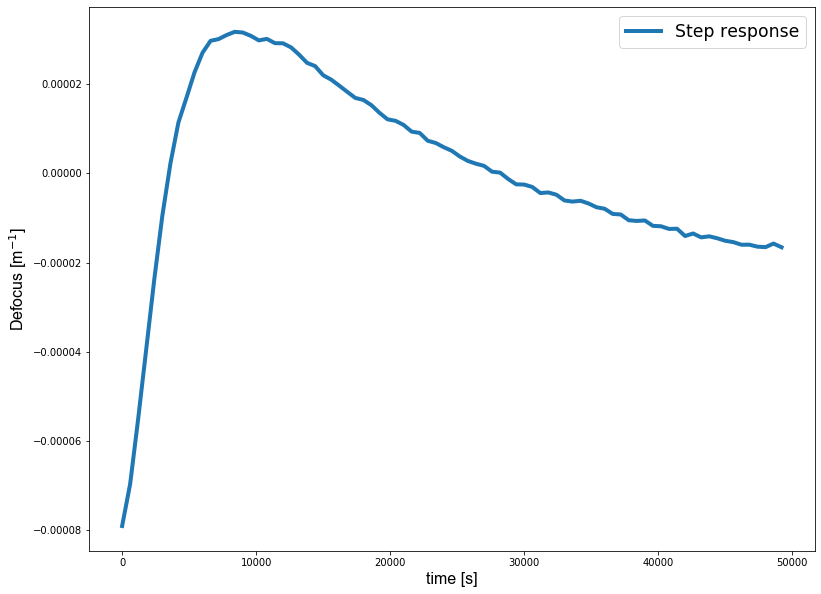

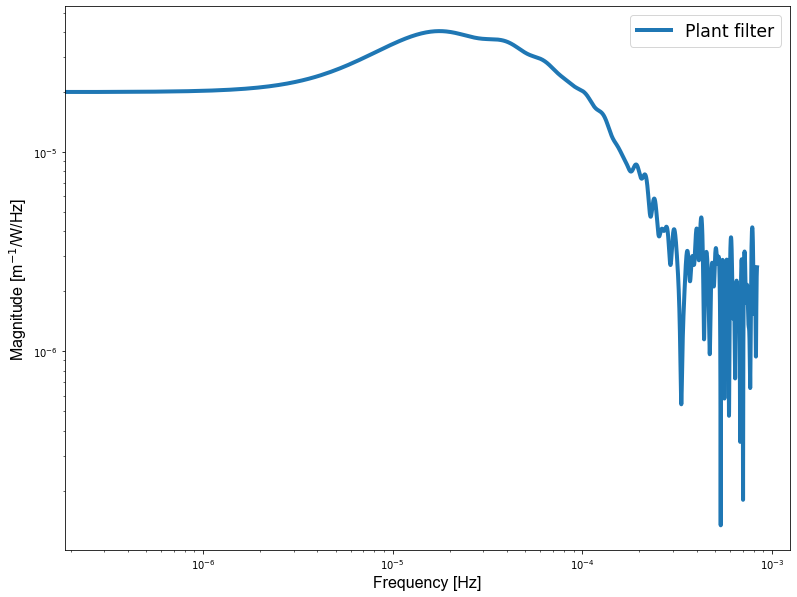

4.993706070287539e-06


In [86]:
ITMYRH_data = np.loadtxt('../data/ITMY_trend_10min_int_longer.dat')
t = np.arange(0,len(ITMYRH_data[:,0][2:]))*60.0*10.0
normalize = 3.13
print(len(t))
data_in = ITMYRH_data[:,1][2:]
b, a = signal.butter(2, .2)
#data_new = signal.filtfilt(b,a,data_in)
data_new = data_in
plt.figure()
ir = (data_new[1:] - data_new[:-1])/normalize
ir_new = ir
fig1 = plt.figure(figsize=(13,10))
plt.plot(t, data_new, label='Step response',linewidth=lin_thickness)
#plt.plot(t[:(len(t)-1)], ir, label= 'Impulse response')
plt.xlabel('time [s]', **axis_font)
plt.ylabel('Defocus [m$^{-1}$]', **axis_font)
plt.legend(fontsize='xx-large')
plt.show()

Fs = 1/(t[2]-t[1])
#print(Fs)

[F,H]=signal.freqz(ir_new,1, worN=3000,whole=False) 
fig2 = plt.figure(figsize=(13,10))
plt.loglog(F*Fs/(2*np.pi), abs(H), label='Plant filter',linewidth=lin_thickness)
plt.ylabel('Magnitude [m$^{-1}$/W/Hz]',**axis_font)
plt.xlabel('Frequency [Hz]',**axis_font)
plt.legend(fontsize='xx-large')
plt.show()

print(max(ir_new))

In [87]:
print('Only plots up to the nyqist frequency: {} Hz'.format(F[-1]*Fs/(2*np.pi)))

Only plots up to the nyqist frequency: 0.0008330555555555556 Hz


9.729529652779821e-12


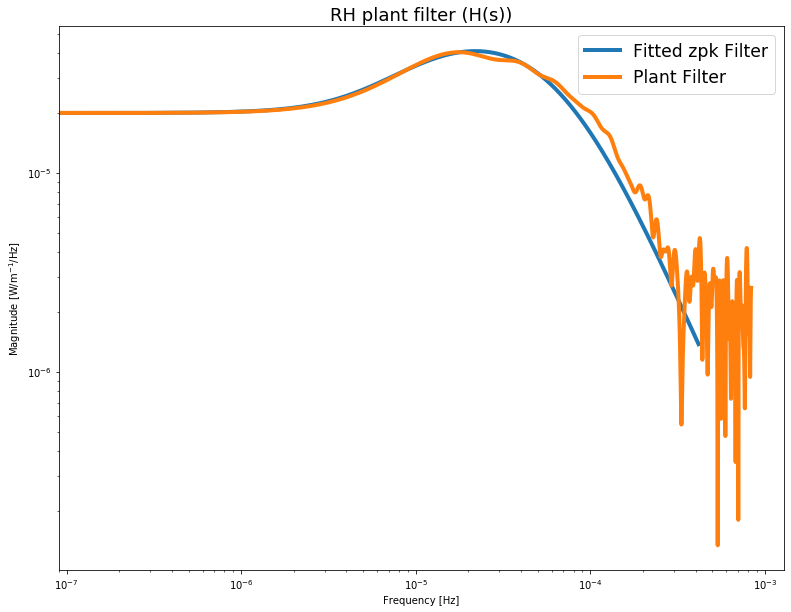

In [88]:
zeros = 5.0e-6
fit_zeros = -2.0*np.pi*5.0e-6
poles = np.array([1.3e-5, 5.0e-5 ,9.5e-5])
fit_poles = -2.0*np.pi*poles

k = 1 #This gain is not initally correct

s1 = signal.ZerosPolesGain(fit_zeros, fit_poles, k)
F_2, H_2 = signal.freqresp(s1, F*(Fs/2.0))

#[F_2,H_2] = signal.freqs(b_2, a_2)
k_new = abs(H[0])/abs(H_2[0])

fig3 = plt.figure(figsize=(13,10))
plt.loglog(F_2/(2*np.pi), abs(H_2)*k_new, label='Fitted zpk Filter',linewidth=lin_thickness)
plt.loglog(F/(2*np.pi)*Fs, abs(H), label='Plant Filter',linewidth=lin_thickness)
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend(fontsize='xx-large')
plt.title('RH plant filter (H(s))',FontSize=18)

print(k_new) #Spit out the new gain

model_zpk = signal.ZerosPolesGain(fit_zeros, fit_poles,k_new)

## Now to invert the plant filter (just swapping the poles and the zeros and inverting gain) (H$^{-1}$(s))

Text(0.5, 1.0, 'RH inverse filter (H$^{-1}$(s))')

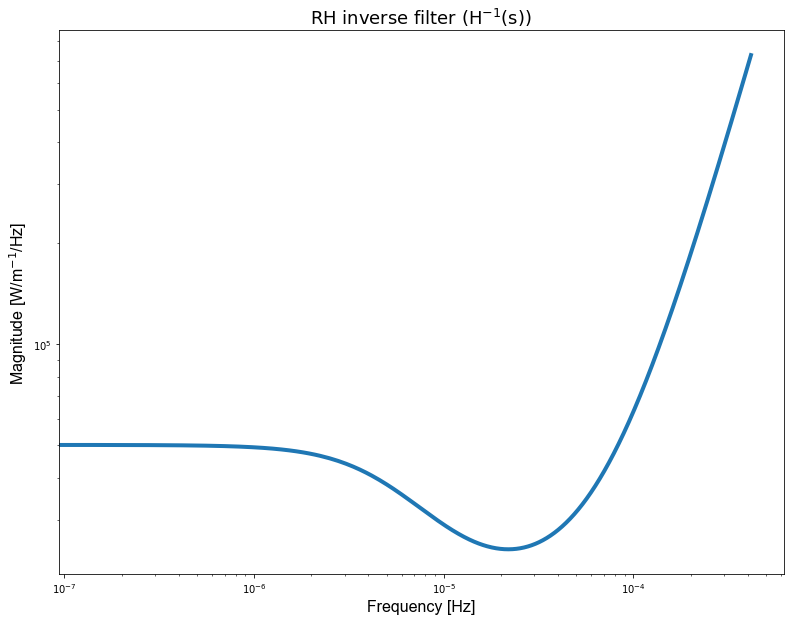

In [89]:
inv_model = signal.ZerosPolesGain(fit_poles, fit_zeros,1/k_new)
F_3, H_3 = signal.freqresp(inv_model, F*(Fs/2.0))
fig4 = plt.figure(figsize=(13,10))
plt.loglog(F_3/(2*np.pi), abs(H_3), label='Fitted zpk Filter',linewidth=lin_thickness)
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]',**axis_font)
plt.xlabel('Frequency [Hz]',**axis_font)
plt.title('RH inverse filter (H$^{-1}$(s))',FontSize=18)

## Stabilize the high frequencies to DC (Generating H$^{-1}$ (s) * G$_{n}$(s)) 
Will also attempt to reduce the time constant

0.999582972876018

/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


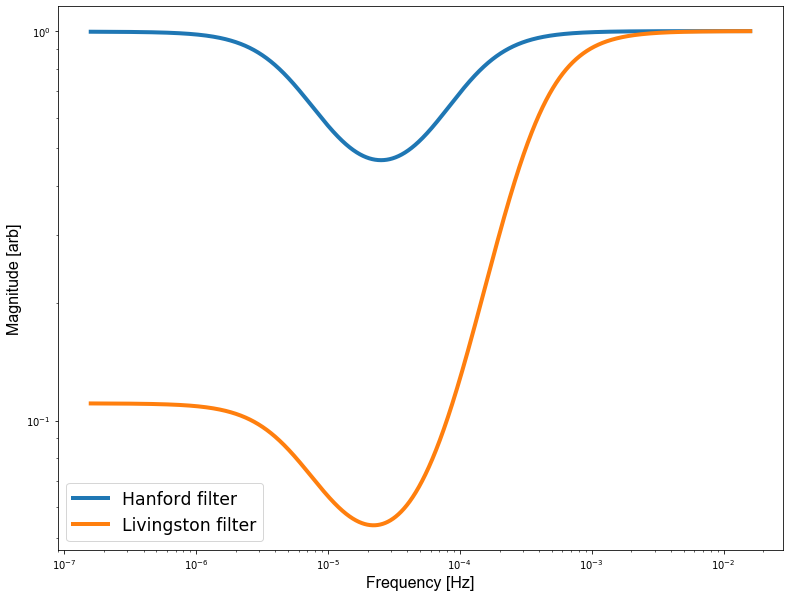

In [208]:
#pole_test = .0001113 + 1e-4
Hinv_G_1_filt = signal.ZerosPolesGain(fit_poles, [fit_zeros,-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],1)
pole_shift = 3
Hinv_G_2_filt = signal.ZerosPolesGain(fit_poles, [fit_zeros,-2.0*np.pi*.0001113129672*pole_shift, -2.0*np.pi*.0001113129672*pole_shift],1)

## Plotting
freq = np.arange(10e-7,10e-2,1e-7)
F_4, H_4 = signal.freqresp(Hinv_G_1_filt,freq)
F_5, H_5 = signal.freqresp(Hinv_G_2_filt,freq)

fig5= plt.figure(figsize=(13,10))
plt.loglog(F_4/(2*np.pi), abs(H_4), label='Hanford filter',linewidth=lin_thickness)
plt.loglog(F_5/(2*np.pi), abs(H_5), label='Livingston filter',linewidth=lin_thickness)

plt.legend(fontsize='xx-large')

plt.ylabel('Magnitude [arb]',**axis_font)
plt.xlabel('Frequency [Hz]',**axis_font)


max(abs(H_4_longer))

# COMSOL self heating filter

## Import COMSOL self heating data

In [209]:
COM_data = np.loadtxt('../data/1W_self_heating_defocus_doublepass.txt')
t_com = COM_data[:,0]*3600
defocus = COM_data[:,1]

Text(0, 0.5, 'defocus [arb]')

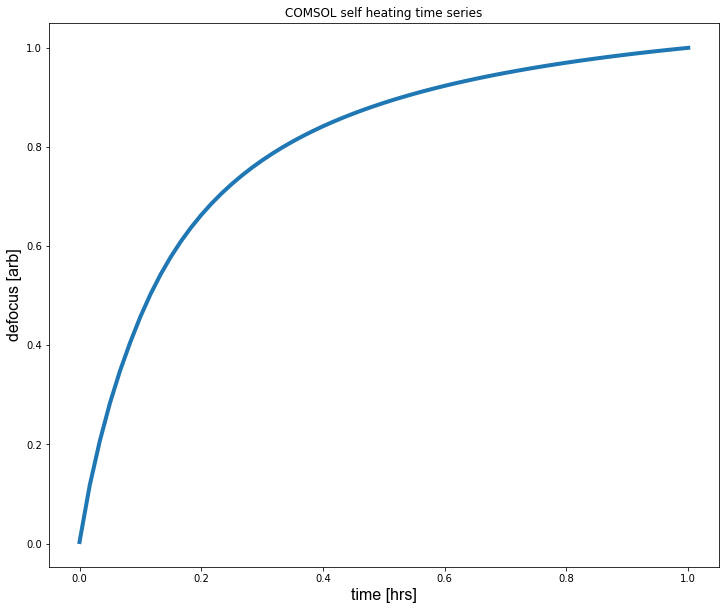

In [210]:
fig6 = plt.figure(figsize=(12,10))
plt.plot(t_com/3600,defocus/np.max(defocus),linewidth=lin_thickness)
plt.title('COMSOL self heating time series')
plt.xlabel('time [hrs]', **axis_font)
plt.ylabel('defocus [arb]', **axis_font)

In [211]:
ir_com  = (defocus[1:] - defocus[:-1])
t_ir = t_com[:((len(t_com)-1))]

In [212]:
[F_ir,H_ir]=signal.freqz(ir_com, 1, worN=3000,whole=False) 
Fs_com =1/(t_com[1]-t_com[0])

Text(0.5, 1.0, 'Self Heating filter (G$_{2}$(s))')

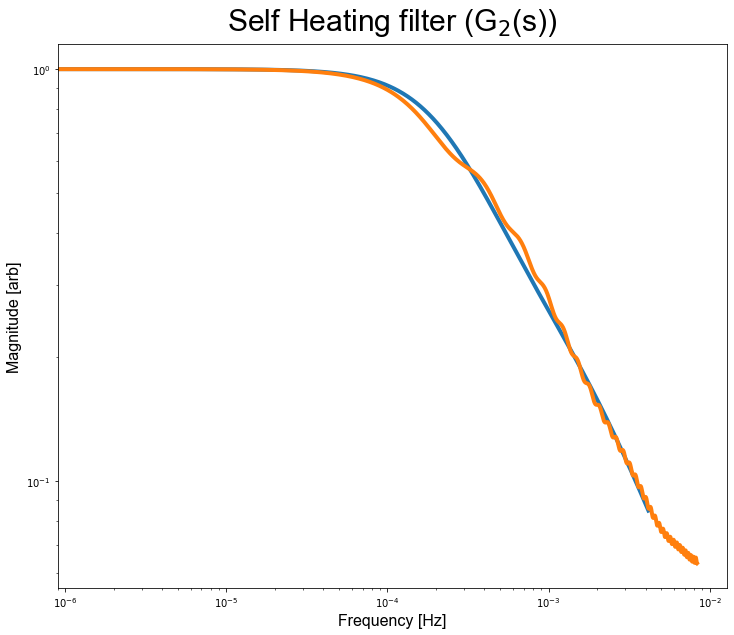

In [213]:
zeros_com = np.array([.9e-3,.3e-3])
fit_zeros_com = -2.0*np.pi*zeros_com
poles_com = np.array([.25e-3,.25e-3,1.6e-3])
fit_poles_com = -2.0*np.pi*poles_com

k_com =1 #This gain is not initally correct

zpk_com = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_com)
F_com, H_com = signal.freqresp(zpk_com, F_ir*(Fs_com/2.0))
k_new_com = abs(H_ir[0])/abs(H_ir[0]*H_com[0])

fig6 = plt.figure(figsize=(12,10))
plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='Fitted zpk Filter',linewidth=lin_thickness)
plt.loglog(F_ir*Fs_com/(2*np.pi), abs(H_ir)/abs(H_ir[0]), label='Plant filter',linewidth=lin_thickness)
plt.ylabel('Magnitude [arb]',**axis_font)
plt.xlabel('Frequency [Hz]',**axis_font)
plt.title('Self Heating filter (G$_{2}$(s))',**title_font)


In [214]:
G_2 = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_new_com)
unit_step_testing = np.zeros(np.shape(t_com))
unit_step_testing[t_com>0] = 1
[ _ ,y_self_test, _] = signal.lsim(G_2, unit_step_testing, t_com)

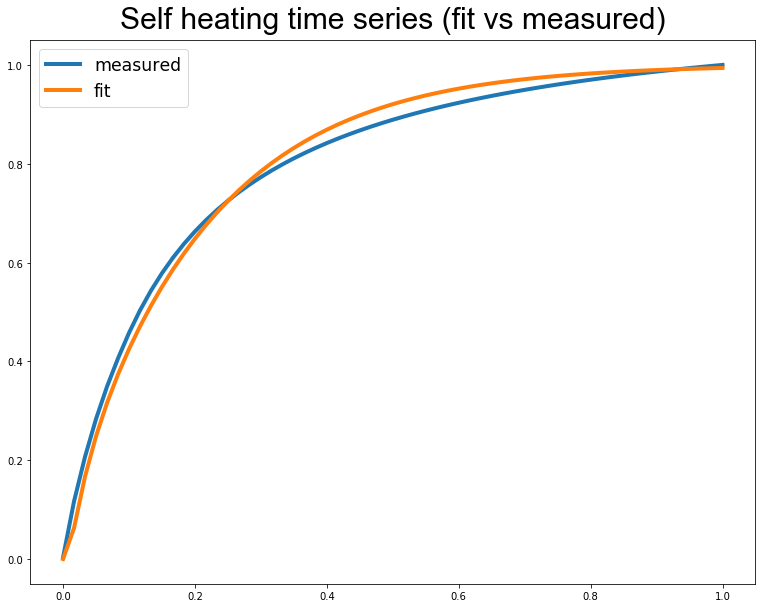

In [215]:
fig7= plt.figure(figsize= (13,10))
plt.plot(t_com/3600,defocus/np.max(defocus),label='measured',linewidth=lin_thickness)
plt.plot(t_com/3600,y_self_test,label='fit',linewidth=lin_thickness)
plt.title('Self heating time series (fit vs measured)',**title_font)
plt.legend(fontsize='xx-large')

# Generating time series

#### Step input time series

In [221]:
unit_step = np.zeros((t.shape[0]*15))
t_new = np.arange(0,len(unit_step))*60.0*1.0
## Generating simulated response
unit_step[t_new>9000] = 1
[t_mod_new,y_mod_sim,xout] = signal.lsim(model_zpk, unit_step, t_new)

#### Conditioned input time series

In [227]:
unit_step2 = np.zeros((t.shape[0]*15))
unit_step2[t_new>(9000)] = pole_shift**2

[ _ ,y_inp_inv_L, _] = signal.lsim(Hinv_G_2_filt, unit_step2, t_new)
[ _ ,y_inp_inv_H, _] = signal.lsim(Hinv_G_1_filt, unit_step, t_new)
[ _ ,y_mod_sim_inv_L, _] = signal.lsim(model_zpk, y_inp_inv_L, t_new)
[ _ ,y_mod_sim_inv_H, _] = signal.lsim(model_zpk, y_inp_inv_H, t_new)

#### Self heating time series

In [228]:
unit_step3 = np.zeros((t.shape[0]*15))
t_offset =0
unit_step3[t_new>(9000+t_offset)] = 1

In [229]:
[ _ ,y_sh_resp, _] = signal.lsim(G_2, unit_step3, t_new)

#### All curves together

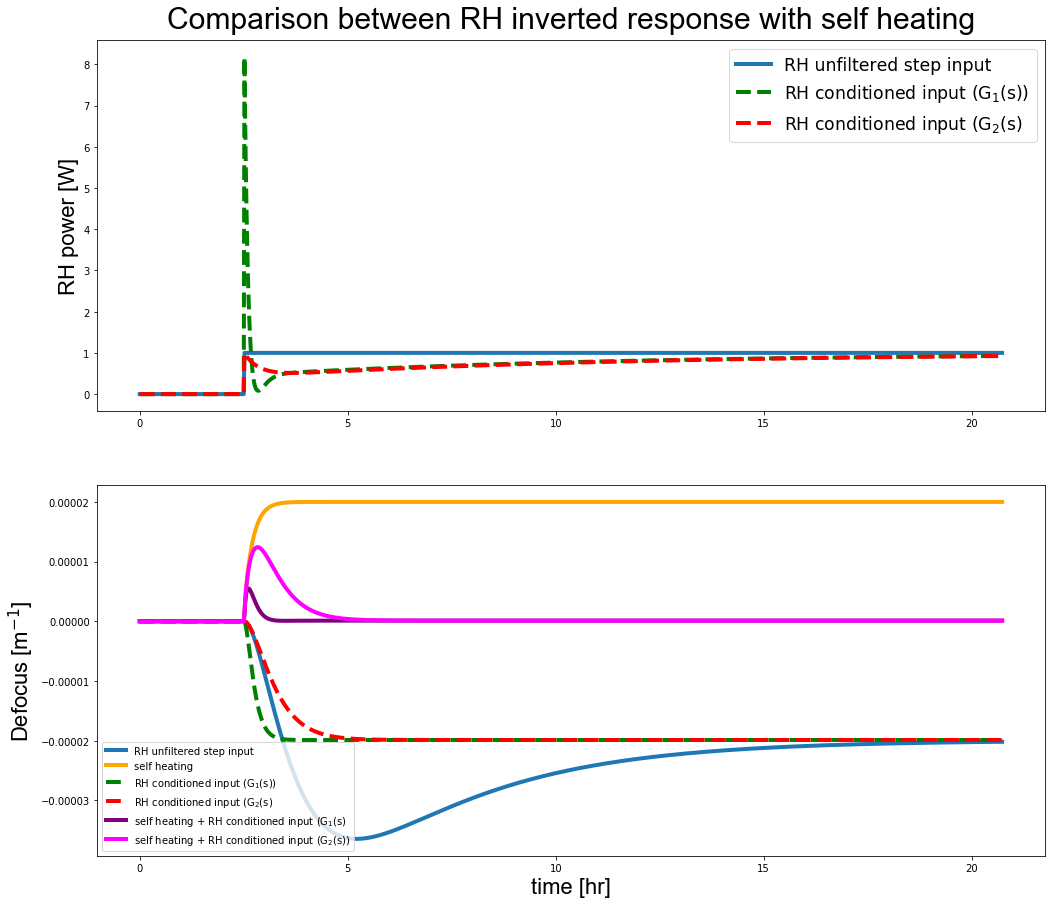

In [303]:
fig = plt.figure(figsize=(17,15))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH unfiltered step input')
plt.plot(t_new/3600, y_inp_inv_L,'--', linewidth = lin_thickness, color = 'green',label='RH conditioned input (G$_{1}$(s))')
plt.plot(t_new/3600, y_inp_inv_H,'--', linewidth = lin_thickness,color = 'red', label='RH conditioned input (G$_{2}$(s)')
plt.ylabel('RH power [W]',**axis_font)
plt.title('Comparison between RH inverted response with self heating',**title_font)
plt.legend(fontsize='xx-large')
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'RH unfiltered step input')
plt.plot(t_new/3600,y_sh_resp*20e-6, linewidth = lin_thickness,color='orange',label ='self heating')
plt.plot(t_new/3600,-y_mod_sim_inv_L,'--', linewidth = lin_thickness,color='green',label ='RH conditioned input (G$_{1}$(s))')
plt.plot(t_new/3600,-y_mod_sim_inv_H,'--', linewidth = lin_thickness,color='red',label ='RH conditioned input (G$_{2}$(s)')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv_L,linewidth = lin_thickness,label='self heating + RH conditioned input (G$_{1}$(s)',color='purple')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv_H,linewidth = lin_thickness,label='self heating + RH conditioned input (G$_{2}$(s))',color='magenta')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize='medium')
fig.savefig('IRHF_compare_self_w_filter_compare.pdf')

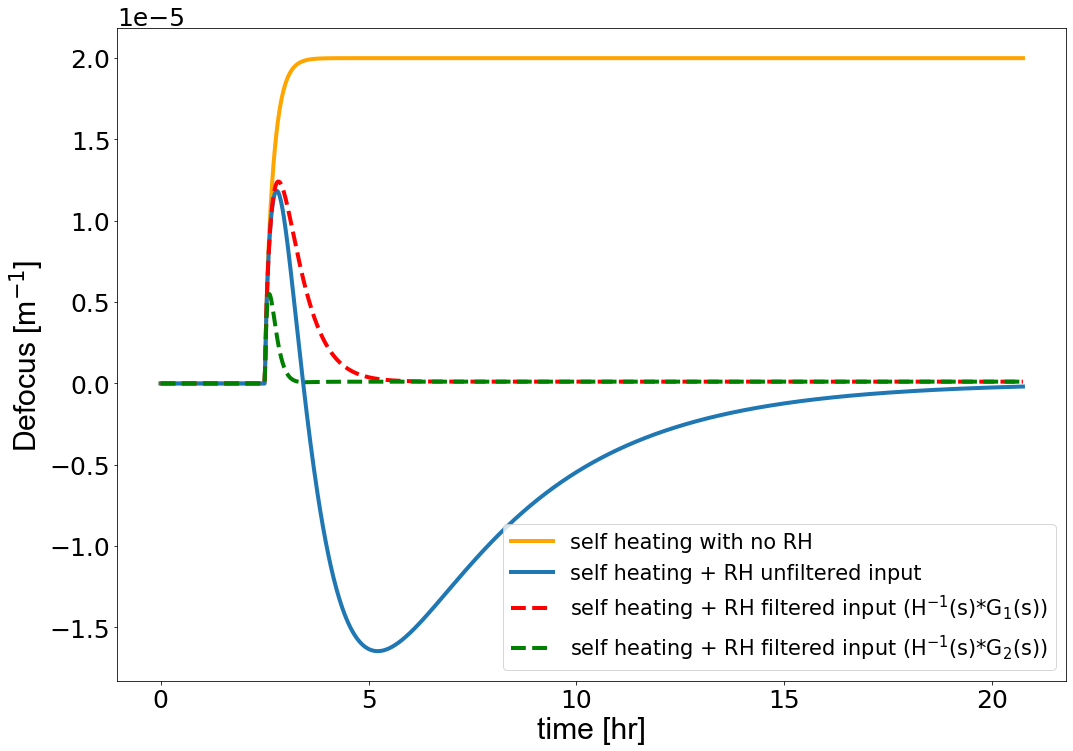

In [412]:
fig = plt.figure(figsize=(17,12))
plt.rc('font', size=25)
#plt.subplot(211)
#plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH unfiltered step input')
#plt.plot(t_new/3600, y_inp_inv_L,'--', linewidth = lin_thickness, color = 'green',label='RH conditioned input (G$_{1}$(s))')
#plt.plot(t_new/3600, y_inp_inv_H,'--', linewidth = lin_thickness,color = 'red', label='RH conditioned input (G$_{2}$(s)')
#plt.ylabel('RH power [W]',**axis_font)
#plt.title('Comparison with central self heating',**title_font)
#plt.legend(fontsize='xx-large')
#plt.subplot(212)
#plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'RH unfiltered step input')
plt.plot(t_new/3600,y_sh_resp*20e-6, linewidth = lin_thickness,color='orange',label ='self heating with no RH')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim,linewidth = lin_thickness,label='self heating + RH unfiltered input',color='C0')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv_H,'--',linewidth = lin_thickness,label='self heating + RH filtered input (H$^{-1}$(s)*G$_{1}$(s))',color='red')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv_L,'--',linewidth = lin_thickness,label='self heating + RH filtered input (H$^{-1}$(s)*G$_{2}$(s))',color='green')
#plt.plot(t_new/3600,-y_mod_sim_inv_L,'--', linewidth = lin_thickness,color='green',label ='RH conditioned input (G$_{1}$(s))')
#plt.plot(t_new/3600,-y_mod_sim_inv_H,'--', linewidth = lin_thickness,color='red',label ='RH conditioned input (G$_{2}$(s))')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,-5))
plt.legend(fontsize='small',loc='best')
fig.savefig('IRHF_compare_w_self.pdf')

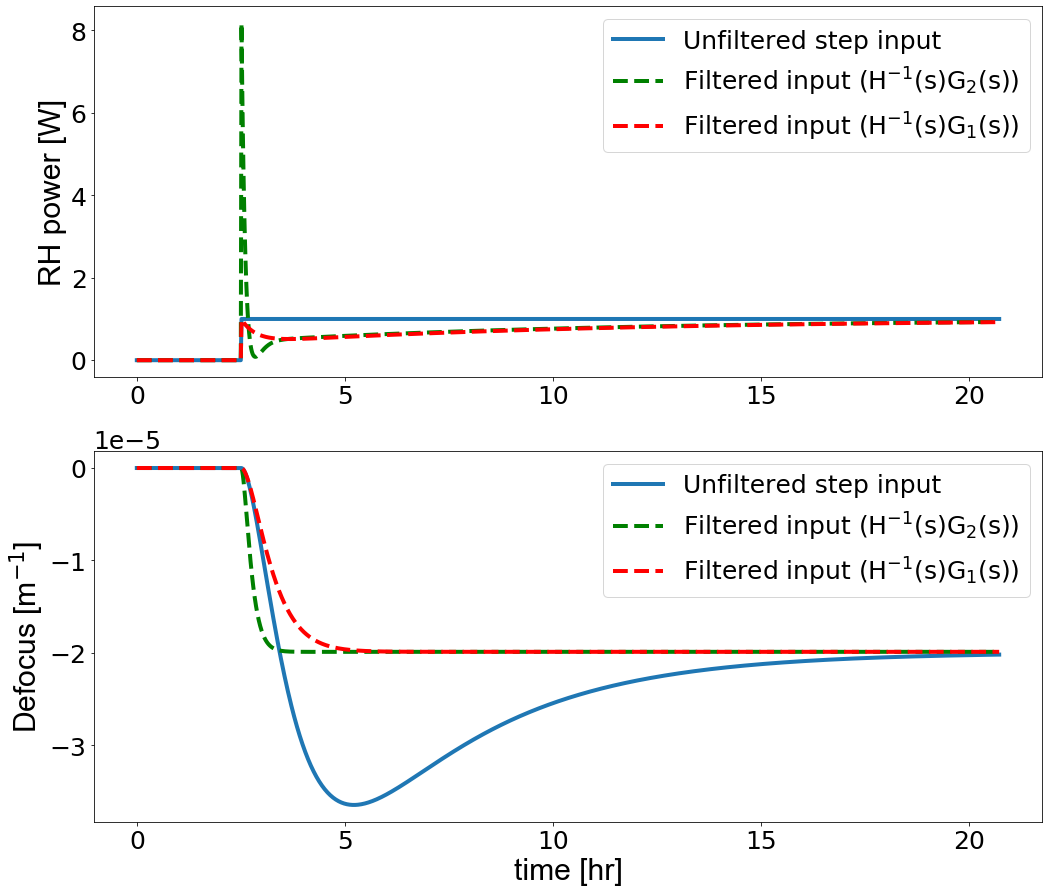

In [407]:
fig = plt.figure(figsize=(17,15))
plt.rc('font', size=25)
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='Unfiltered step input')
plt.plot(t_new/3600, y_inp_inv_L,'--', linewidth = lin_thickness, color = 'green',label='Filtered input (H$^{-1}$(s)G$_{2}$(s))')
plt.plot(t_new/3600, y_inp_inv_H,'--', linewidth = lin_thickness,color = 'red', label='Filtered input (H$^{-1}$(s)G$_{1}$(s))')
plt.ylabel('RH power [W]',**axis_font)
#plt.title('RH responses',**title_font)
plt.legend(fontsize='medium')
plt.subplot(212)
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'Unfiltered step input')
plt.plot(t_new/3600,-y_mod_sim_inv_L,'--', linewidth = lin_thickness,color='green',label ='Filtered input (H$^{-1}$(s)G$_{2}$(s))')
plt.plot(t_new/3600,-y_mod_sim_inv_H,'--', linewidth = lin_thickness,color='red',label ='Filtered input (H$^{-1}$(s)G$_{1}$(s))')
plt.xlabel('time [hr]',**axis_font)
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,-5))
plt.legend(fontsize='medium')
fig.savefig('IRHF_compare_filts.pdf')

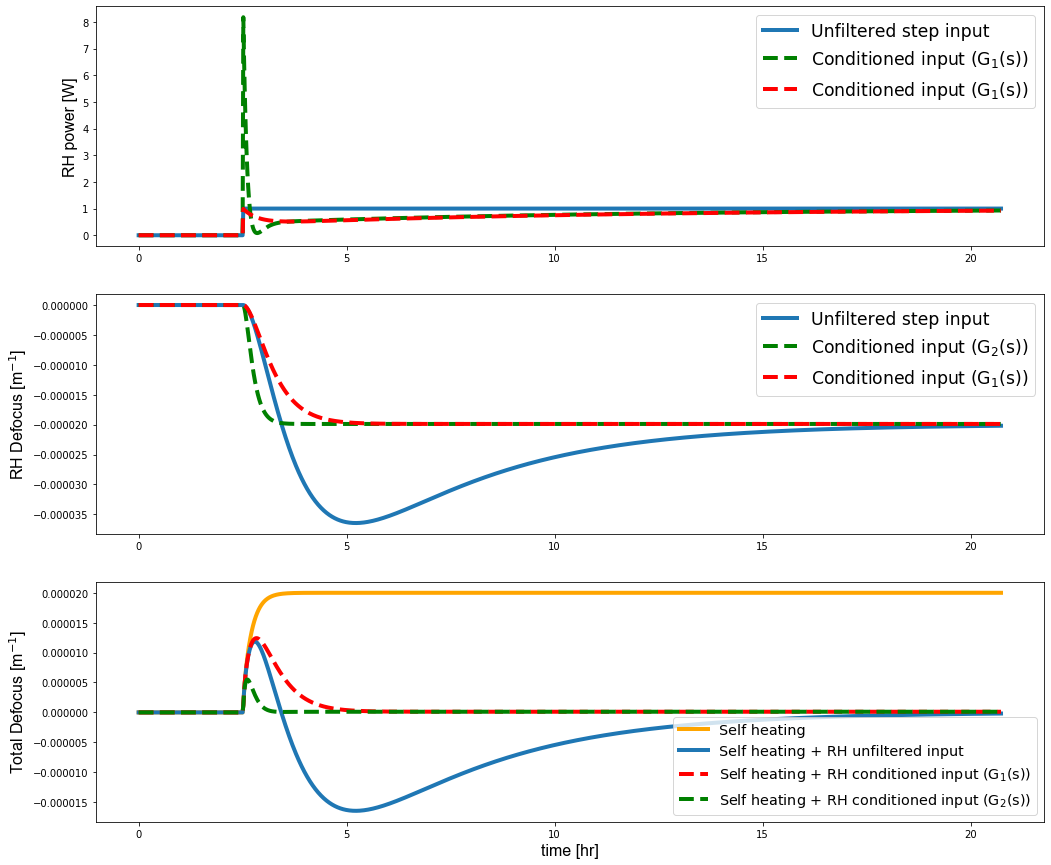

In [287]:
fig = plt.figure(figsize=(17,15))
plt.subplot(311)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='Unfiltered step input')
plt.plot(t_new/3600, y_inp_inv_L,'--', linewidth = lin_thickness, color = 'green',label='Conditioned input (G$_{1}$(s))')
plt.plot(t_new/3600, y_inp_inv_H,'--', linewidth = lin_thickness,color = 'red', label='Conditioned input (G$_{1}$(s))')
plt.ylabel('RH power [W]',**axis_font)
#plt.title('RH responses',**title_font)
plt.legend(fontsize='xx-large')
plt.subplot(312)
plt.ylabel('RH Defocus [m$^{-1}$]',**axis_font)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'Unfiltered step input')
plt.plot(t_new/3600,-y_mod_sim_inv_L,'--', linewidth = lin_thickness,color='green',label ='Conditioned input (G$_{2}$(s))')
plt.plot(t_new/3600,-y_mod_sim_inv_H,'--', linewidth = lin_thickness,color='red',label ='Conditioned input (G$_{1}$(s))')
plt.legend(fontsize='xx-large')
plt.subplot(313)
plt.plot(t_new/3600,y_sh_resp*20e-6, linewidth = lin_thickness,color='orange',label ='Self heating')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim,linewidth = lin_thickness,label='Self heating + RH unfiltered input',color='C0')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv_H,'--',linewidth = lin_thickness,label='Self heating + RH conditioned input (G$_{1}$(s))',color='red')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv_L,'--',linewidth = lin_thickness,label='Self heating + RH conditioned input (G$_{2}$(s))',color='green')
plt.ylabel('Total Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize='x-large')
fig.savefig('IRHF_compare_all.pdf')

In [231]:
max(abs(y_sh_resp*20e-6 -y_mod_sim_inv*9))

0.00015903662083091127

In [242]:
y_sh_resp[-1]*20e-6-y_mod_sim_inv[-1]

1.097380341887813e-07

# G$_{1}$(s) -> The "response function"

Text(0.5, 0, 'Frequency [Hz]')

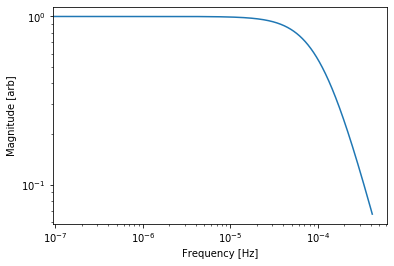

In [405]:
#For the above scenario we have the following G_s (a double pole low pass at 1.113e-4)
G_1 = signal.ZerosPolesGain([], [-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],1)
F_5, H_5 = signal.freqresp(G_1,F*(Fs/2.0))
k_upd = 1/abs(H_5[0])
G_1 = signal.ZerosPolesGain([], [-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],k_upd)
plt.loglog(F_5/(2*np.pi), abs(H_5)*k_upd, label='Fitted zpk Filter')
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')

#### Deriving the above filter is achieved by assuming a double pole solution. We are using poles in order to reduce the gain at relatively high frequency (to avoid implementing a unstable and unphysical filter. The reason we need two is to balance out the number of poles and zeros. The value of the chosen pole frequency is achieved by setting the ratio of the poles to zeros equal to 1.

# Alternative response function (G$_{2}$(s) w/ self heating?)

## To preface this discussion, the 2nd order low pass filter appears to be one of two solutions: 
    ## At Hanford we use the 2nd order low pass (G$_{1}$(s) but as of this moment is not used to perform dynamic thermal compensation.
    ## At Livinston they use the self heating response to inform the final form of their filter

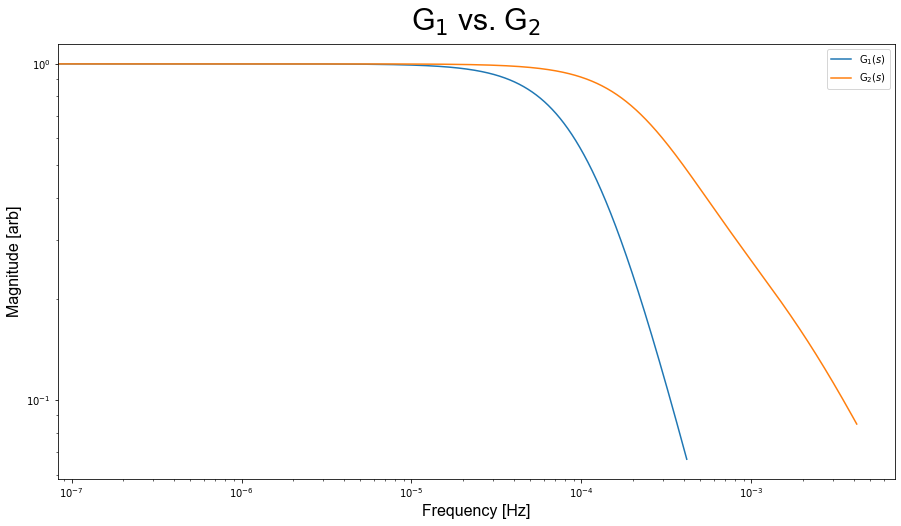

In [434]:
fig2 = plt.figure(figsize=(15,8))
plt.loglog(F_5/(2*np.pi), abs(H_5)*k_upd, label='G$_{1}(s)$')
plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='G$_{2}(s)$')
plt.ylabel('Magnitude [arb]',**axis_font)
plt.xlabel('Frequency [Hz]',**axis_font)
plt.title('G$_{1}$ vs. G$_{2}$',**title_font)
plt.legend()

## The Livingston filter is what we will construct here. To do that, we will first attempt multiplying G$_{2}$(s) (the self heating response) to H$^{-1}$(s)

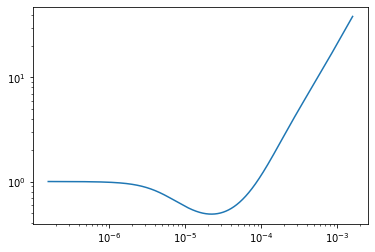

In [435]:
FILT_LIV_zeros= np.append(fit_zeros_com,fit_poles)
FILT_LIV_poles= np.append(fit_poles_com,fit_zeros)
FILT_LIV = signal.ZerosPolesGain(FILT_LIV_zeros, FILT_LIV_poles, 1)
_ , H_G2 = signal.freqresp(FILT_LIV,np.arange(10e-7,10e-3,1e-7))
plt.loglog(np.arange(10e-7,10e-3,1e-7)/(2*np.pi), abs(H_G2)/abs(H_G2[0]))

## Not enough zeros to set high frequency to unity gain (would be an unphysical without one more pole)

In [438]:
FILT_LIV_poles_2= np.append(FILT_LIV_poles,-0.00020951281288038756)

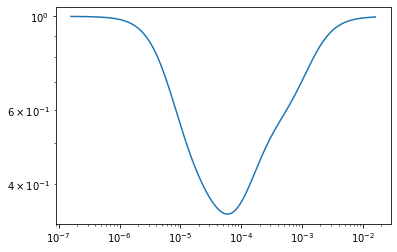

In [439]:
FILT_LIV = signal.ZerosPolesGain(FILT_LIV_zeros, FILT_LIV_poles_2, 1)
_ , H_G2 = signal.freqresp(FILT_LIV,freq)
plt.loglog(freq/(2*np.pi), abs(H_G2)/abs(H_G2[0]))

In [440]:
[ _ ,y_G2, _] = signal.lsim(FILT_LIV, unit_step, t_new)

In [441]:
[ _ ,y_G2_time, _] = signal.lsim(model_zpk, y_G2, t_new)

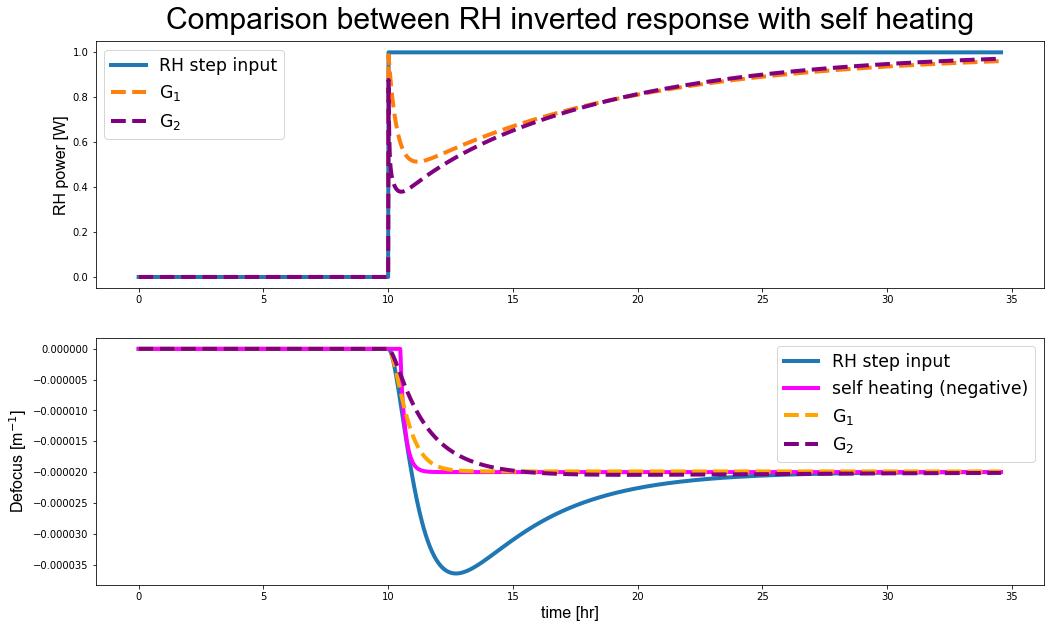

In [445]:
fig = plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH step input')
plt.plot(t_new/3600, y_inp_inv,'--', linewidth = lin_thickness,label='G$_{1}$')
plt.plot(t_new/3600,y_G2,'--', linewidth = lin_thickness,color='purple',label ='G$_{2}$')
plt.ylabel('RH power [W]',**axis_font)
plt.title('Comparison between RH inverted response with self heating',**title_font)
plt.legend(fontsize='xx-large')
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'RH step input')
plt.plot(t_new/3600,-y_sh_resp*20e-6, linewidth = lin_thickness,color='magenta',label ='self heating (negative)')
plt.plot(t_new/3600,-y_mod_sim_inv,'--', linewidth = lin_thickness,color='orange',label ='G$_{1}$')
#plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv,linewidth = lin_thickness,label='diff (orange - green)',color='red')
plt.plot(t_new/3600,-y_G2_time,'--', linewidth = lin_thickness,color='purple',label ='G$_{2}$')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize='xx-large')
fig.savefig('G1_and_G2.pdf')